In [1]:
import eurostat
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from datetime import datetime
from functools import reduce

import warnings
warnings.filterwarnings("ignore")

In [2]:
settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5, 
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)

%config InlineBackend.figure_format = "retina"

In [3]:
#### WHERE TO SAVE DATA'
output = "../output_mo_qt/"
figures = "../figures/"	

In [4]:
# BOP https://www.dnb.nl/en/statistics/data-search/#/details/balance-of-payments-quarter/dataset/5b160938-6940-4a6e-89b1-fccc027194c6/resource/9df04bfa-aa59-44d1-8a5d-e92af5569c7a
import requests
import json

url = 'https://api.dnb.nl/statisticsdata/v2024100101/balance-sheet-of-de-nederlandsche-bank-month-non-break-adjusted?page=1&pageSize=15360&sort=period asc'
response = requests.get(url, headers={'Ocp-Apim-Subscription-Key': '22705b2ed8d94fc3823a88079e890baf',})
response_dict = json.loads(response.text)


### Interest Rates

In [5]:
url = 'https://api.dnb.nl/statisticsdata/v2024100101/european-central-bank-interest-rates?page=1&pageSize=100000&sort=period asc'
response = requests.get(url, headers={'Ocp-Apim-Subscription-Key': '22705b2ed8d94fc3823a88079e890baf'})

response_dict = json.loads(response.text)

In [6]:
rawdata = pd.DataFrame.from_dict(response_dict['records'])
typeOfRate = rawdata['typeOfRate'].unique()

In [7]:
interestRates = []
for i in typeOfRate:
    rawdata2 = rawdata[rawdata['typeOfRate'] == i]
    rawdata2.sort_values('period', inplace=True)
    rawdata2.fillna(method='ffill', inplace=True)
    rawdata2['date'] = pd.to_datetime(rawdata2['period'], utc=True).dt.to_period(freq="D")
    rawdata2.set_index('date', inplace=True, drop=True)
    rawdata2.index = rawdata2.index.to_timestamp()
    rawdata2.drop(columns=['period', 'typeOfRate'], inplace=True)
    rawdata2.rename(columns={'value': i}, inplace=True)
    interestRates.append(rawdata2)
    

In [8]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,how='outer'), interestRates)

<Axes: >

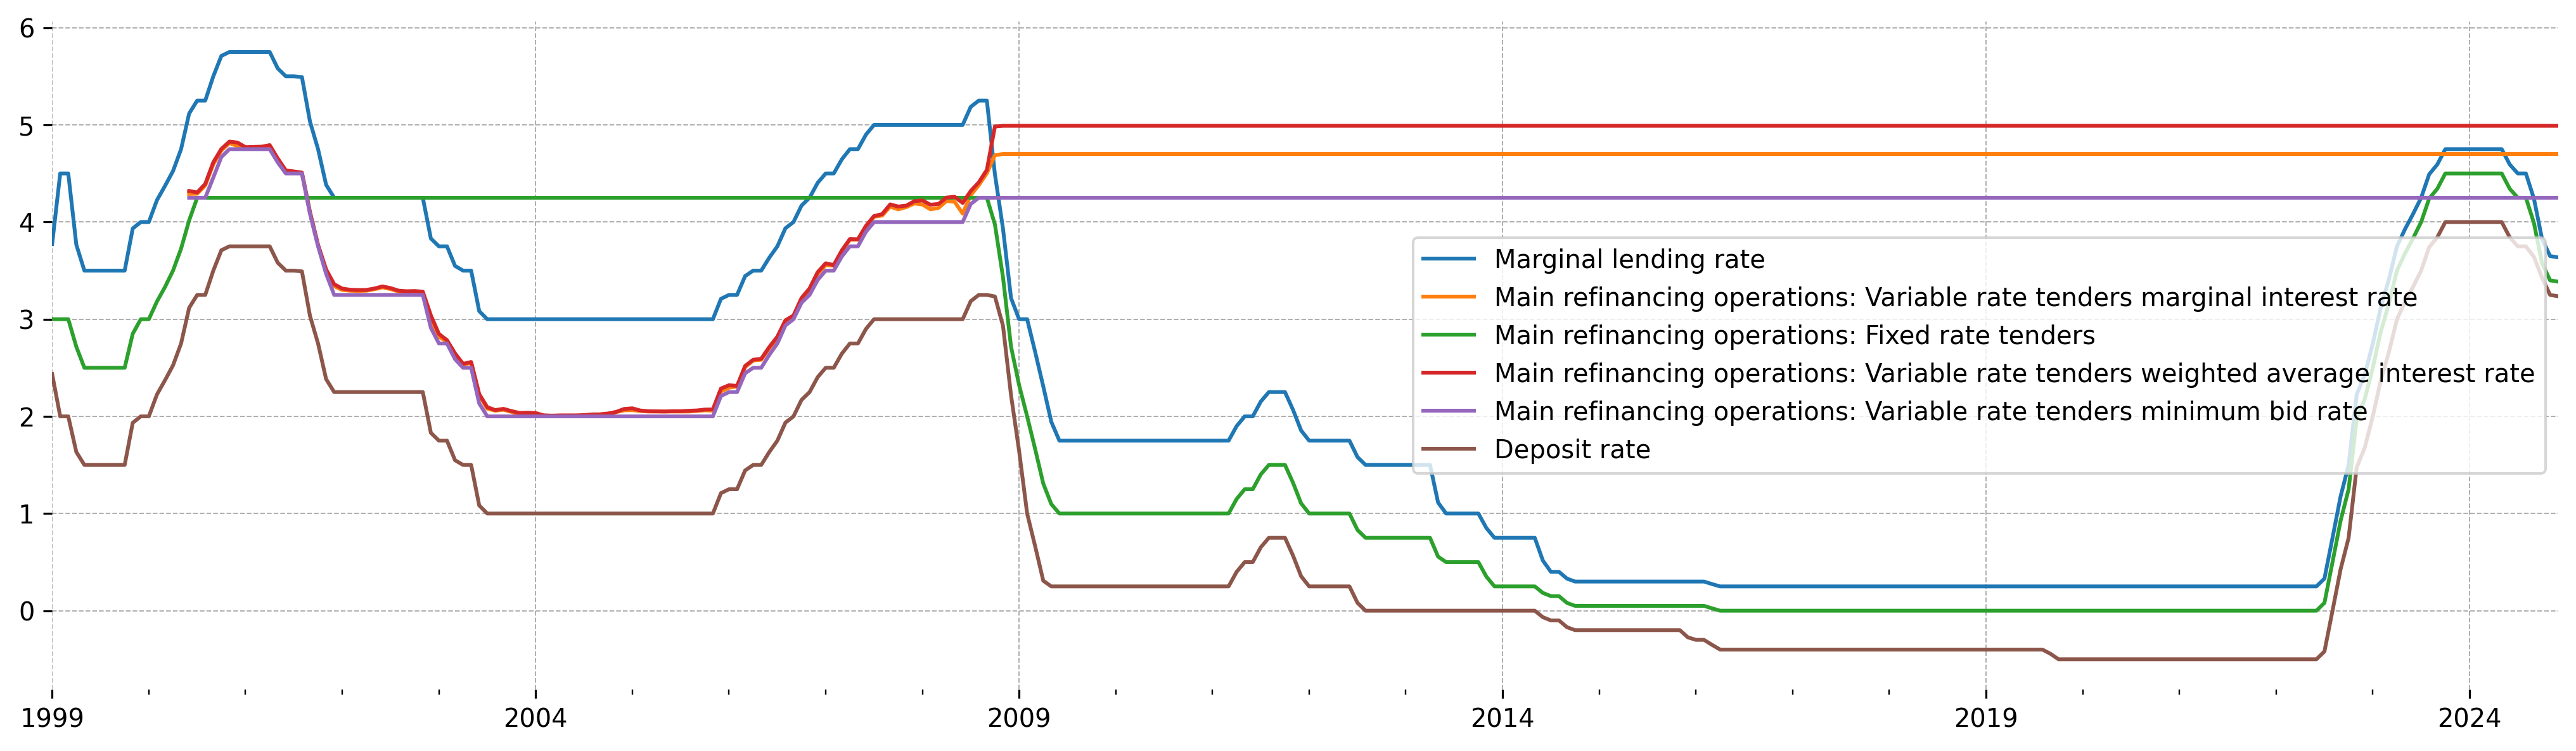

In [9]:
allDates = pd.date_range(start=df_merged.index.min(), end=df_merged.index.max(), freq='D')
df2 = pd.DataFrame(index=allDates)
interestRate = df2.merge(df_merged, left_index=True, right_index=True, how='left')
interestRate.fillna(method='ffill', inplace=True)
interestRate = interestRate.resample('1MS').mean()
interestRate.to_csv(output + "interestRates_mo.csv")
interestRate.plot()

Money supply


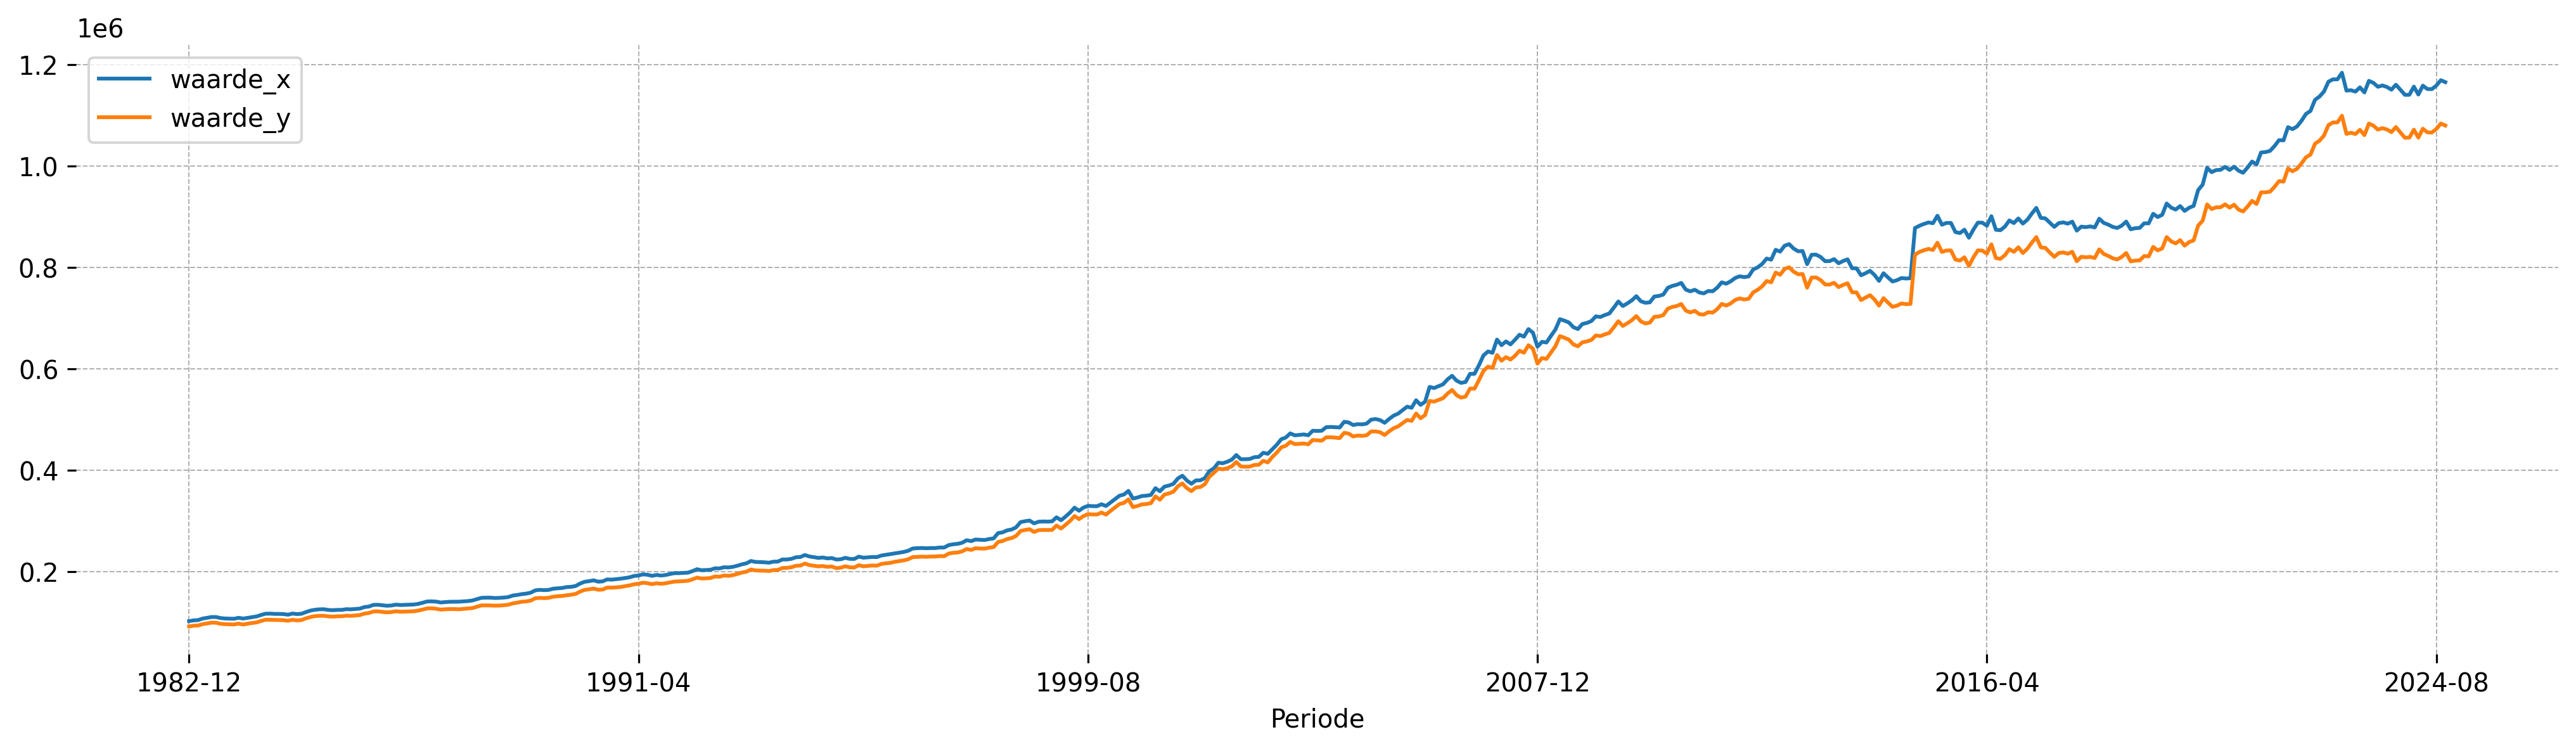

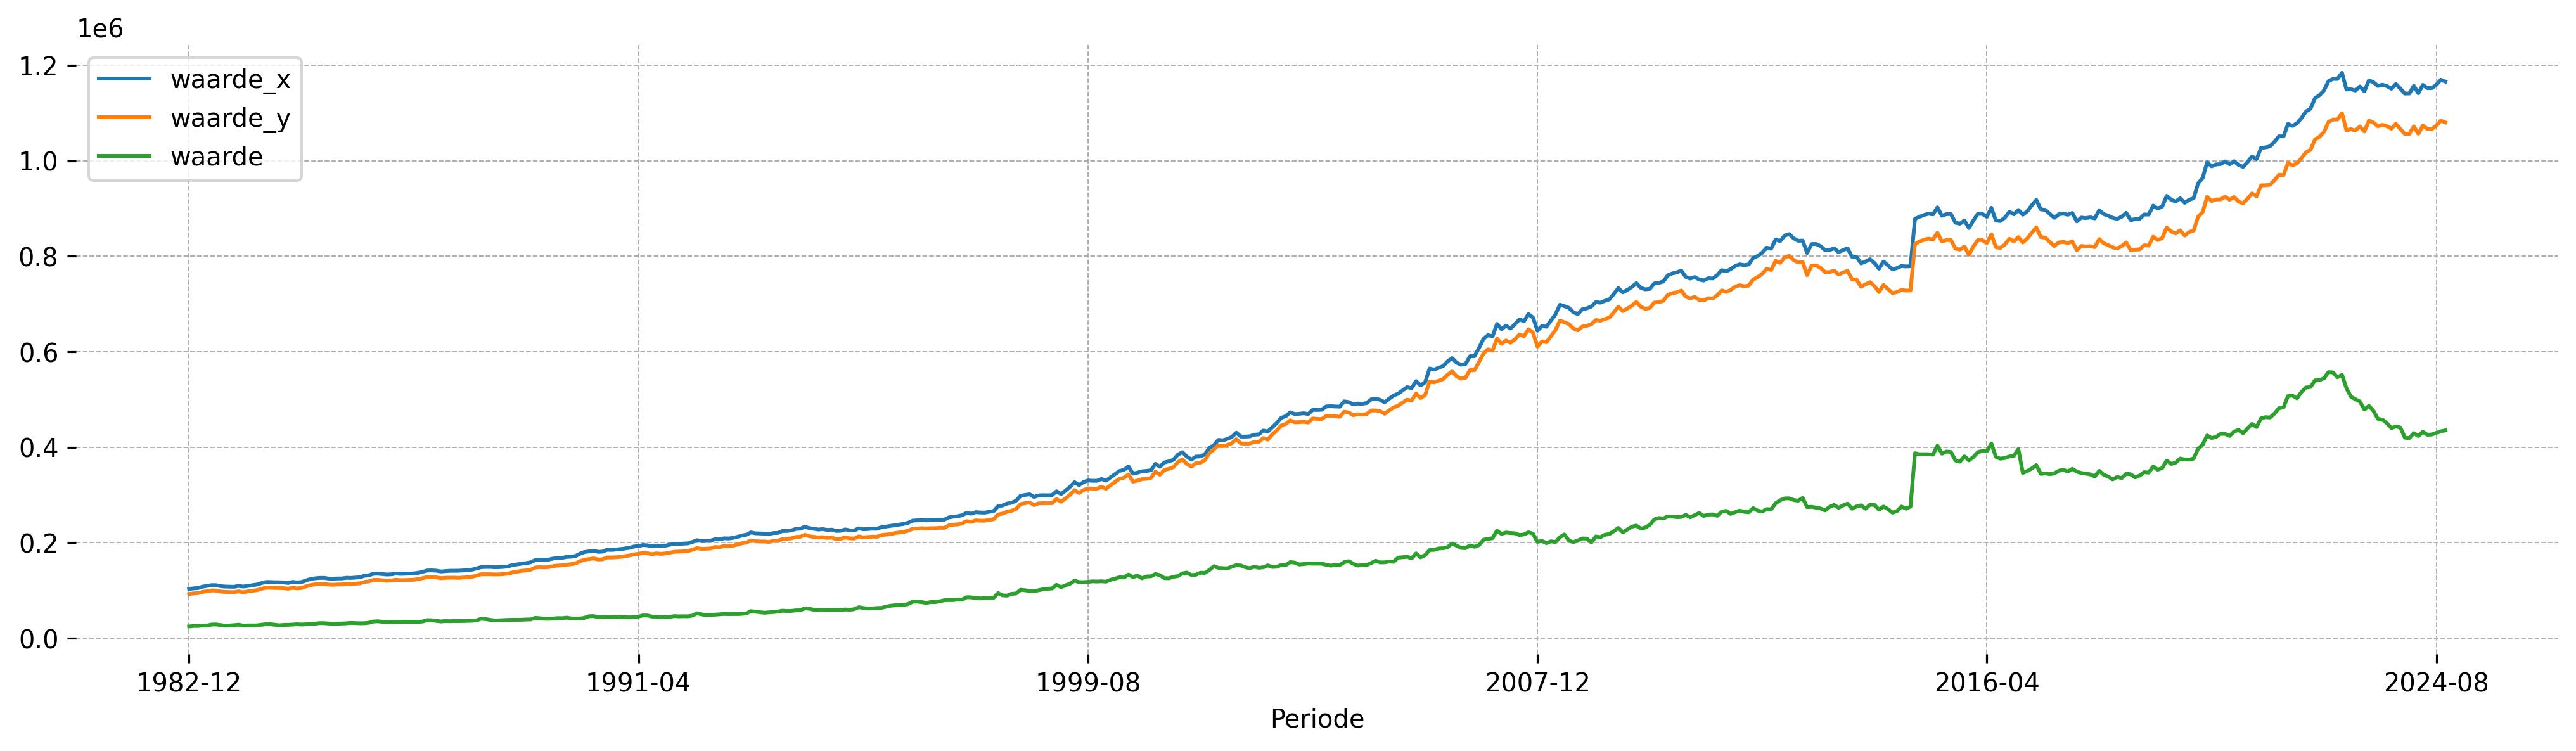

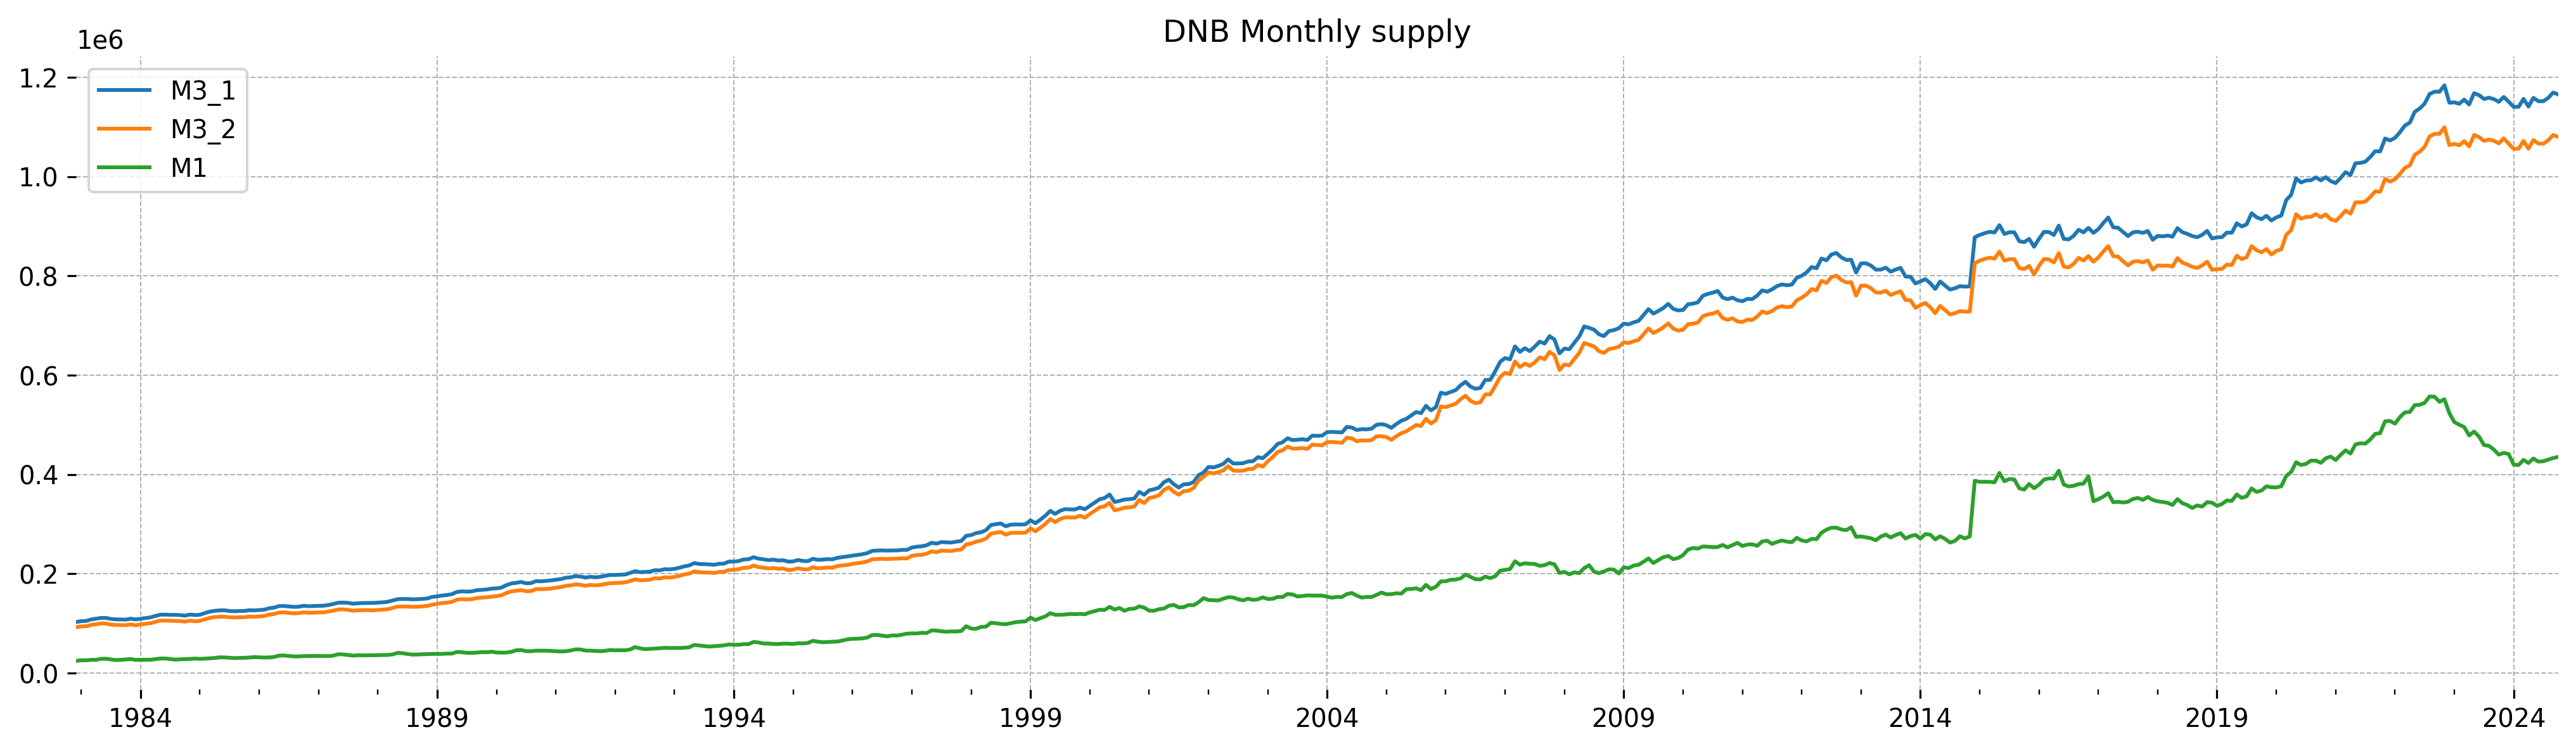

In [10]:
#############################
# M1 must be calculated from csv (easy)
# from DNB
# Bancaire rente op uitstaande woninghyoptheken van huishoundens in Nederland
# https://www.dnb.nl/statistieken/data-zoeken/#/details/bijdrage-van-nederland-aan-monetaire-aggregaten-in-het-eurogebied-maand/dataset/2639cea8-012c-4202-bb06-51e76bedfeb4/resource/8d1a3cde-6dd8-4207-acb9-8940fc9efe07
##############################

def moneysupply(verbose = False):

    print("Money supply")
    M1 = pd.read_csv('../data/(10-12-24)_Bijdrage_van_Nederland_aan_monetaire_aggregaten_in_het_eurogebied_(Maand).csv')

    M1.rename(columns=lambda x: x.strip(), inplace=True)
    M1['Instrument'] = M1['Instrument'].str.strip()
    M1['Periode'] = M1['Periode'].str.strip()
    M1['Soort'] = M1['Soort'].str.strip()
    M1['StandStroom'] = M1['StandStroom'].str.strip()
    M1['Instrument'] = M1['Instrument'].str.strip()

    ############################################
    # M3-inclusive
    M3 = M1[M1['StandStroom'] == 'Standen']
    M3 = M3[M3['Soort'] == 'Aanvullende gegevens']
    M3 = M3[M3['Instrument'] == 'M3 (inclusief chartaal geld in omloop)'][['Periode', 'waarde']]
    M3.drop_duplicates(subset = 'Periode', keep="last", inplace=True)
    M3.set_index('Periode', inplace=True)

    if verbose:
        print(M3)
        M3.plot()
        plt.title("M3-inclus")
        plt.show()
        M3.to_csv("m3.csv")

    # M3-exclusive
    M3_ex = M1[M1['StandStroom'] == 'Standen']
    M3_ex = M3_ex[M3_ex['Soort'] == 'M3-componenten']
    M3_ex = M3_ex[M3_ex['Instrument'] == 'M3 (exclusief chartaal geld in omloop)'][['Periode', 'waarde']]
    M3_ex.drop_duplicates(subset = 'Periode', keep="last", inplace=True)
    M3_ex.set_index('Periode', inplace=True)

    M3_measures_mo = M3.merge(M3_ex, left_index=True, right_index=True, how = 'outer')
    M3_measures_mo.plot()

    if verbose:
        print(M3_ex)
        M3_ex.plot()
        plt.title("M3-exclus")
        plt.show()
    #M3_measures_mo.to_csv("data_mo/M3_measures_mo.csv")

    ############################################
    giral = M1[M1['StandStroom'] == 'Standen']
    giral = giral[giral['Soort'] == 'M3-componenten']
    giral = giral[giral['Instrument'] == 'Girale deposito\'s'][['Periode', 'waarde']]
    giral.drop_duplicates(subset = 'Periode', keep="last", inplace=True)
    giral.set_index('Periode', inplace=True)

    M3_giral_measures_mo = M3_measures_mo.merge(giral, left_index=True, right_index=True, how = 'outer')
    M3_giral_measures_mo.plot()

    if verbose:
        print("giral: ", giral)
        giral.plot()
        plt.show()

    M3_giral_measures_mo.columns = ["M3_1", "M3_2", "M1"]
    M3_giral_measures_mo.index.name = None
    M3_giral_measures_mo.index = pd.date_range(start='12/01/1982', periods=M3_giral_measures_mo.shape[0], freq="M").to_period('M')
    M3_giral_measures_mo.index = pd.PeriodIndex(M3_giral_measures_mo.index, freq='M').to_timestamp()

    return M3_giral_measures_mo

data = moneysupply(verbose = False)
data.to_csv(output + "dnb_M3_giral_measures_mo.csv")

data.plot()
plt.title('DNB Monthly supply')
plt.savefig(figures + "dnb_M3_giral_measures_mo.png")
plt.show()



Dutch interest rates


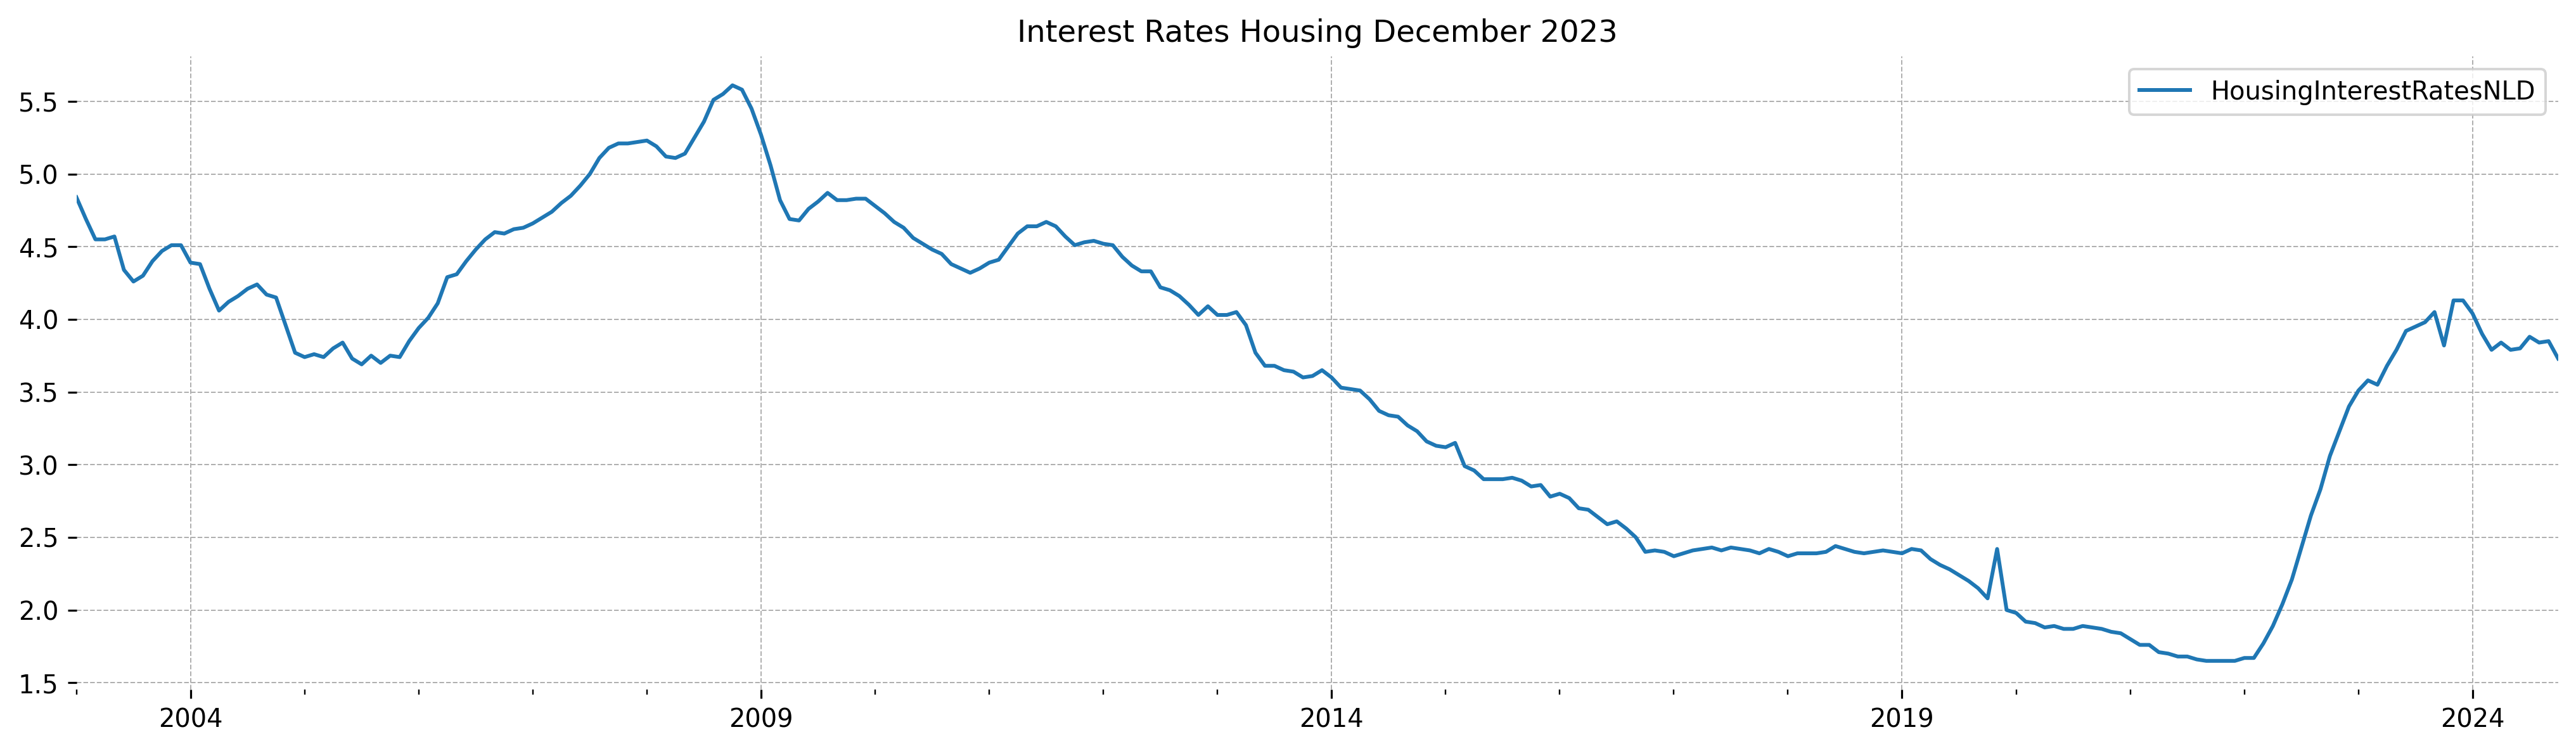

In [11]:


#############################
# Rente
# https://www.dnb.nl/statistieken/data-zoeken/#/details/kernindicatoren-monetaire-statistieken-maand/dataset/b698ca40-9cae-435b-954e-4fe2c5651370/resource/a8df8430-d941-4706-907b-efd5a9c0bc00
#############################

def renteNetherlands():

    print("Dutch interest rates")
    data = pd.read_csv('../data/(10-12-24)_Kernindicatoren_monetaire_statistieken_(Maand).csv')
    data.rename(columns=lambda x: x.strip(), inplace=True)
    data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    data = data[data['Instrument'] == 'Woninghypotheken']
    data = data[data['InstrumentSub'] == "Rente op nieuwe contracten, inclusief heronderhandelingen (percentages)"]
    data.rename(columns = {"Rente op nieuwe contracten, inclusief heronderhandelingen (percentages)": "houseInterestRate"}, inplace = True)
    data.index = pd.date_range(start='01/01/2003', periods=data.shape[0], freq="M").to_period('M')
    data.index = pd.PeriodIndex(data.index, freq='M').to_timestamp()
    data = data[["waarde"]]
    data.columns = ['HousingInterestRatesNLD']

    return data

data = renteNetherlands()
data.to_csv(output + "dnb_interestrates_mo.csv")
data.plot()
plt.title('Interest Rates Housing December 2023')
plt.savefig(figures + "/dnb_interestrates_mo.png")
plt.show()



Dutch Business interests rates


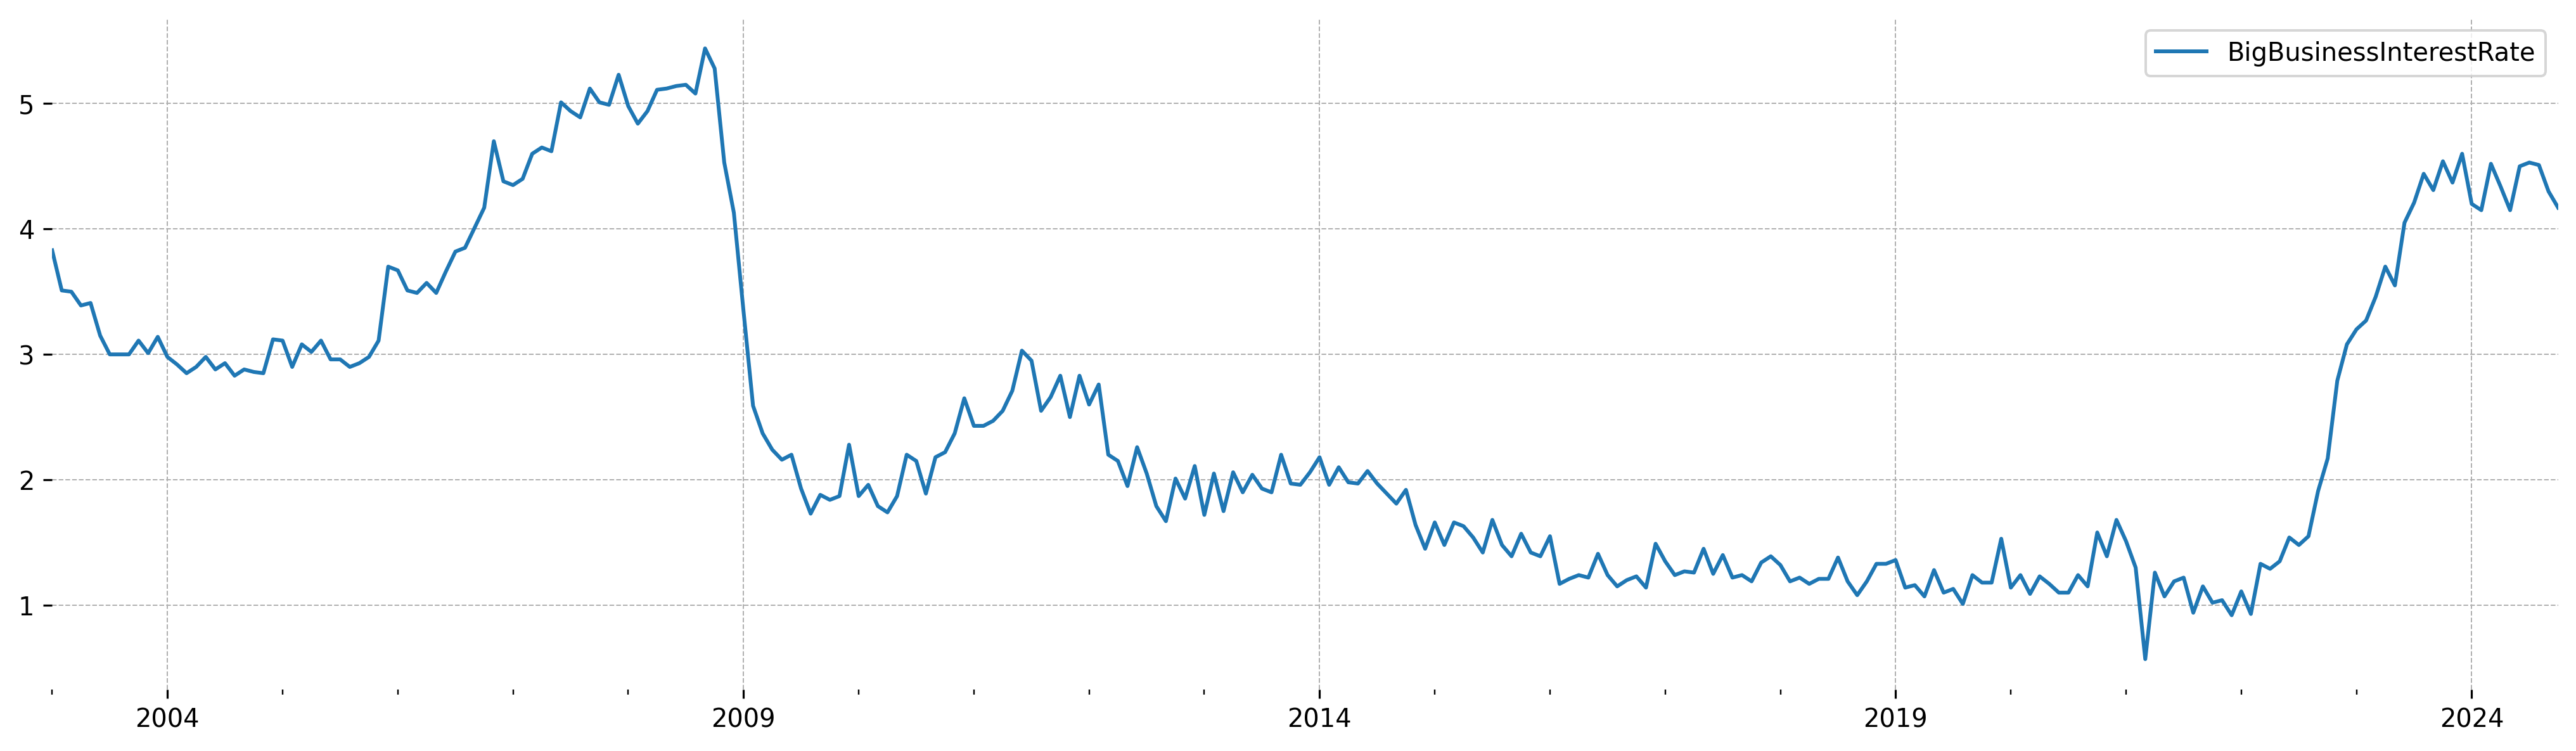

In [12]:

def zakerenteNetherlands():

    print("Dutch Business interests rates")
    data = pd.read_csv('../data/(10-12-24)_Kernindicatoren_monetaire_statistieken_(Maand).csv')
    data.rename(columns=lambda x: x.strip(), inplace=True)
    data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    data = data[data['Instrument'] == "Zakelijke kredietverlening"]
    data = data[data['InstrumentSub'] == "Rente op nieuwe contracten > € 1 mln (percentages)"]
    data.rename(columns = {"Rente op nieuwe contracten > € 1 mln (percentages)  ": "BigBusinessInterestRate"}, inplace = True)
    data.index = pd.date_range(start='01/01/2003', periods = data.shape[0], freq="M").to_period('M')
    data.index = pd.PeriodIndex(data.index, freq='M').to_timestamp()
    data = data[["waarde"]]
    data.columns = ['BigBusinessInterestRate']

    return data

data = zakerenteNetherlands()
data.plot()
plt.show()
data.to_csv(output + "dnb_bigbusinessinterestrates_mo.csv")


Dutch Business outstanding


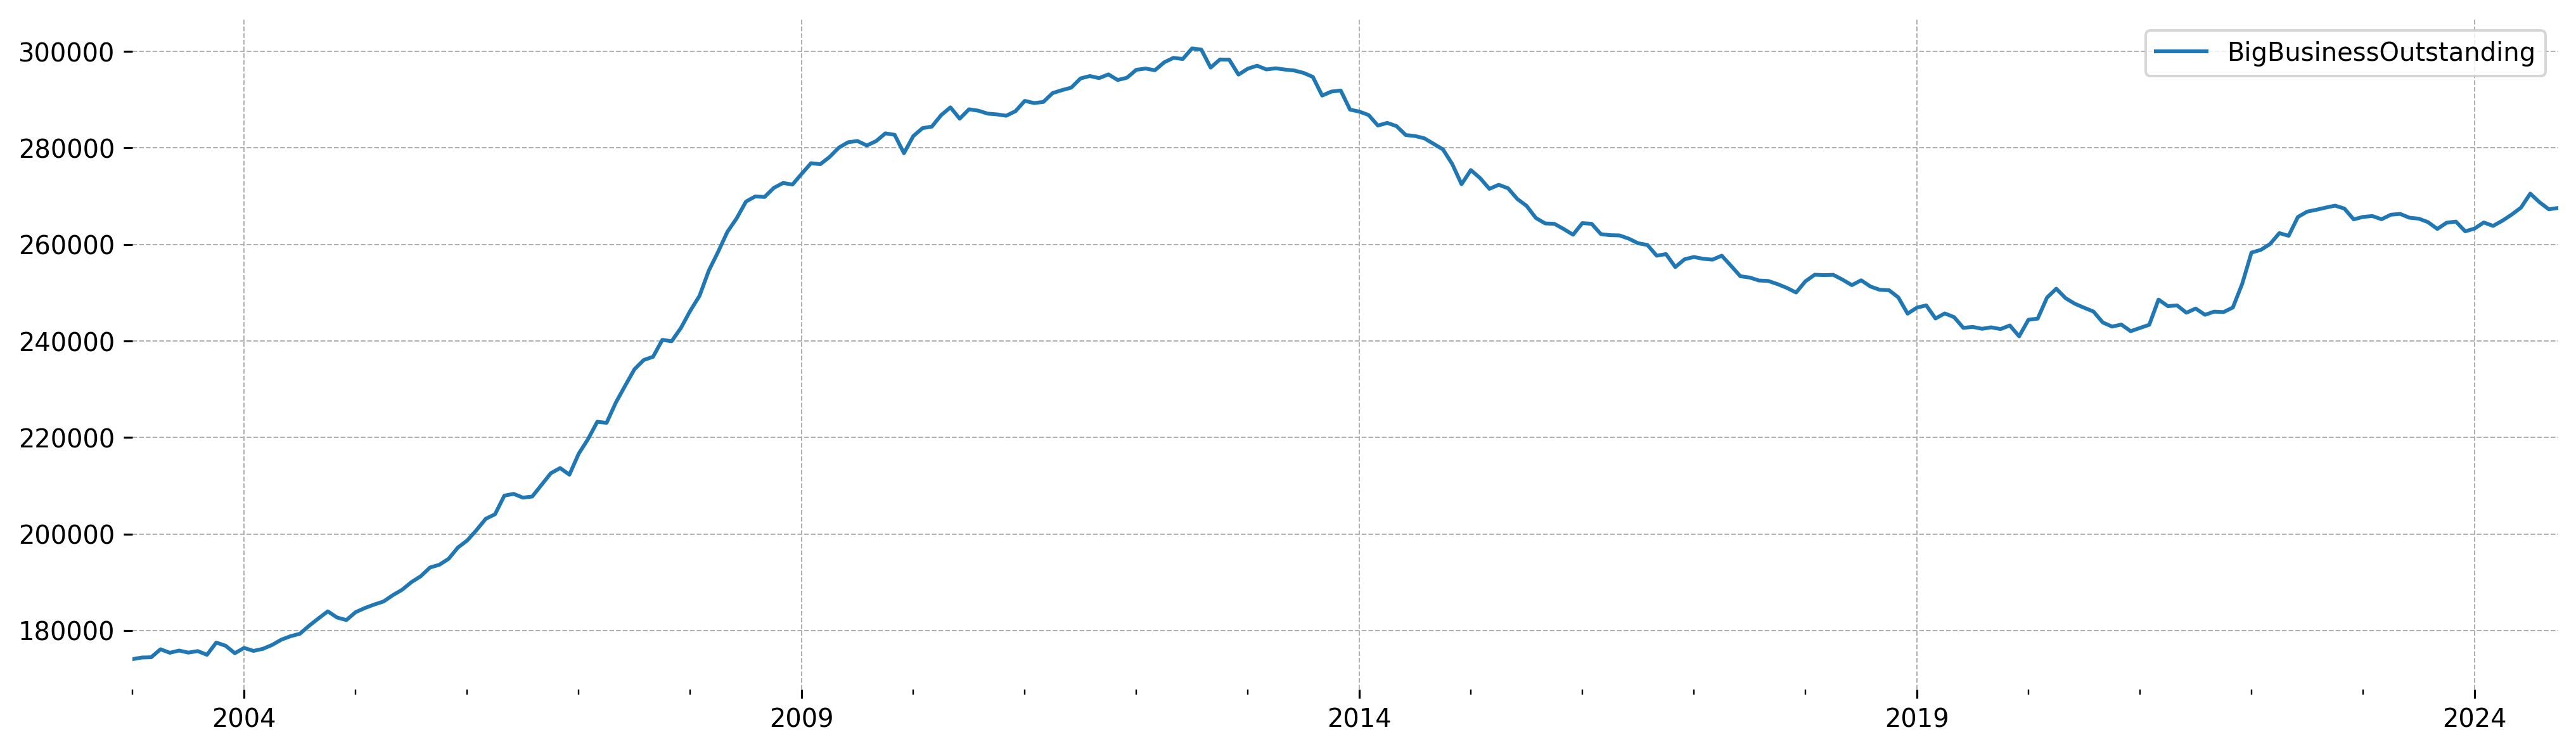

In [13]:


def dnb_bigbusinessOutstanding_mo():

    print("Dutch Business outstanding")
    data = pd.read_csv('../data/(10-12-24)_Kernindicatoren_monetaire_statistieken_(Maand).csv')
    data.rename(columns=lambda x: x.strip(), inplace=True)
    data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    data = data[data['Instrument'] == "Zakelijke kredietverlening"]
    data = data[data['InstrumentSub'] == "Uitstaande bedragen (mln euro's)"]
    data.rename(columns = {"Uitstaande bedragen (mln euro's)": "BigBusinessOutstanding"}, inplace = True)
    data.index = pd.date_range(start='01/01/2003', periods=data.shape[0], freq="M").to_period('M')
    data.index = pd.PeriodIndex(data.index, freq='M').to_timestamp()
    data = data[["waarde"]]
    data.columns = ['BigBusinessOutstanding']

    return data

data = dnb_bigbusinessOutstanding_mo()
data.plot()
plt.show()
data.to_csv(output + "dnb_bigbusinessOutstanding_mo.csv")



savings amounts


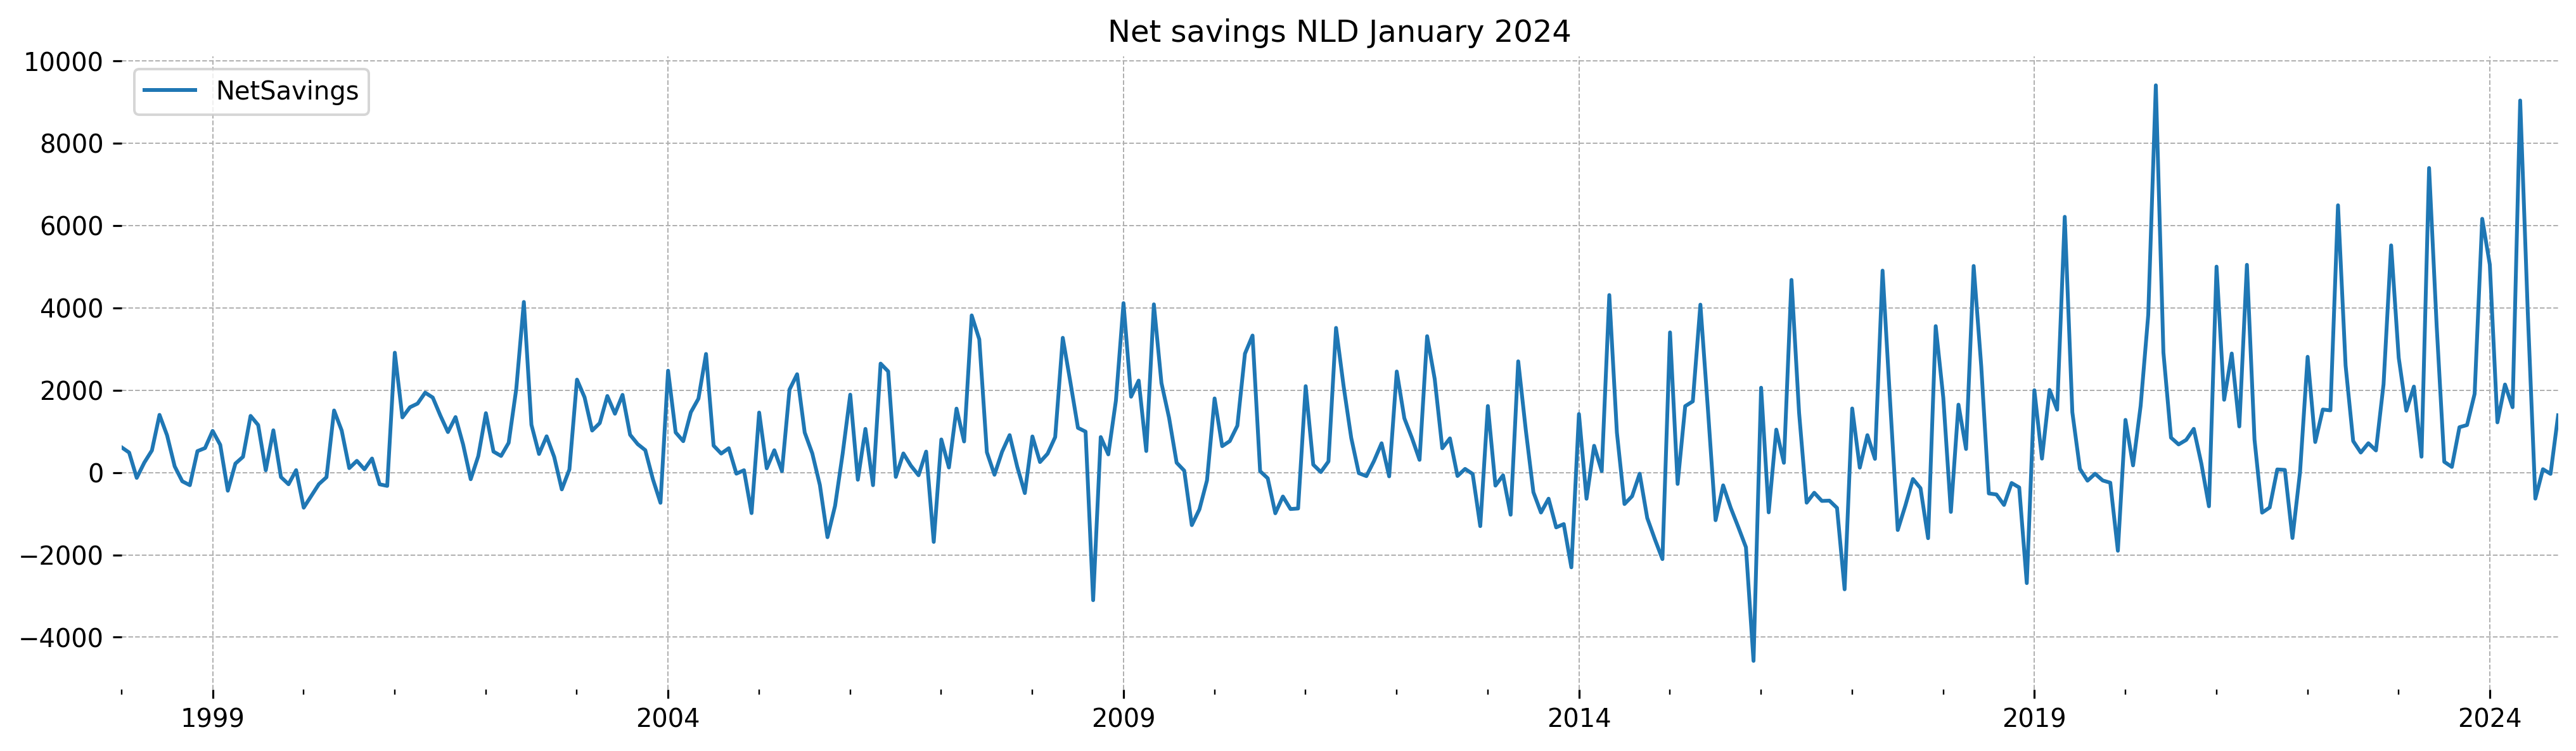

In [14]:

#############################
# Savings
# https://www.dnb.nl/statistieken/data-zoeken/#/details/spaargeld-van-nederlandse-huishoudens-maand/dataset/6ef46471-d025-421e-ac01-1631a996c7c7/resource/7d127f00-6917-4e63-a163-08afd65ecb1a
#############################

def savingsNetNetherlands():
    print("savings amounts")
    data = pd.read_csv('../data/(10-12-24)_Spaargeld_van_Nederlandse_huishoudens_(Maand).csv')
    data = data[data['Instrument'] == 'Totaal spaargeld ']
    data = data[data['StandStroom'] == 'Netto inleg ']
    data.index = pd.date_range(start='01/01/1998', periods=data.shape[0], freq="M").to_period('M')
    data = data[['waarde']]
    data.index = pd.PeriodIndex(data.index, freq='M').to_timestamp()
    data.rename(columns={"waarde": "NetSavings"}, inplace = True)

    return data

data = savingsNetNetherlands()
data.to_csv(output + "dnb_savingsnet_mo.csv")
data.plot()
plt.title('Net savings NLD January 2024')
plt.savefig(figures + "dnb_savingsnet_mo.png")
plt.show()